# Amazon Book Review Text Analysis
****
This project uses Amazon book review data obtained from UCSD to achieve the following:

1) Understand how favorably readers find books on average from the star rating system and determine the most frequently used words and bi-grams in review text.

2) Create a Naive Bayes model to predict star rating of review based on textual analysis.

3) Recommend books based on topics determined through LDA that are included in favorable reviews by the user.

## Data Importation

In [17]:
from __future__ import with_statement
import pandas as pd
import time
import threading

def readProducts(path, reviews, reviewsLock, released, releasedLock, products, productsLock, merged, mergedLock):
  #open the file at the specified path
  with open(path, 'rb') as f:
    
    #For every line in the compressed file
    for line in f:
        if len(merged) < 500000: #set limit of a million reviews read in
            lineDict = eval(line)

            #get the product key
            asin = str(lineDict.get('asin'))
            if asin == None:
              del asin
              del lineDict
              del line
              continue

            #get the categories
            categories = lineDict.get('categories')

            #if categories exists and 'books' is not a category for the product, we can discard the product
            if categories != None:
                #sanitize the categories into lowercase (for some reason categories is a list of lists that is always length 1
                sanitizedCategories = [x.lower() for x in categories[0]]

                #if books is not in categories, skip this product and delete the vars created, free mem
                if 'books' not in sanitizedCategories:
                    del lineDict
                    del line
                    del asin
                    del categories
                    del sanitizedCategories
                    continue
                #otherwise delete the categories objects to free memory
                else:
                    del categories
                    del sanitizedCategories

            #if the asin has been released by the review processor, merge it
            if asin in released:

                #remove released asin from released list to free memory
                with releasedLock:
                    released.remove(asin)

                #for each review that has been processed, merge in metadata
                for review in reviews[asin]:
                    updatedReview = getWantedDataFromReviewAndProduct(review, lineDict)

                    with mergedLock:
                      merged.append(updatedReview)

                    #cleanup
                    del updatedReview
                    del review

                with reviewsLock:
                    del reviews[asin]
            else:
                #otherwise, add relevant product metadata to product dict
                with productsLock:
                    products[asin] = {'title': lineDict.get('title')}

            #cleanup objects in memory immediately
            del lineDict
            del asin
            del line
        else:
            break

def readReviews(path, reviews, reviewsLock, released, releasedLock, products, productsLock, merged, mergedLock):
  #open the file at the specified path
  with open(path, 'rb') as f:
    
    #for every line in the compressed file
    previousAsin = 'Initial'
    
    
    for line in f:
        if len(merged) < 500000:
            lineDict = eval(line)

            #get the product key
            asin = str(lineDict.get('asin'))
            if asin == None:
                del lineDict
                del line
                continue

            if asin in reviews:
                #if the product key is already in the reviews map, append the new review
                with reviewsLock:
                    reviews[asin].append(lineDict)
            else:
                #otherwise add this review as the first in the dict
                with reviewsLock:
                    reviews[asin] = [lineDict]

            if previousAsin != asin:
                #if previous asin is different from the next, we've added all reviews for that asin since file is organized by asin 

                #if the preivous asin has been read into products
                if previousAsin in products:

                    #get the product metadata
                    productMetadata = products.get(previousAsin)

                    #cleanup processed product, free memory
                    with productsLock:
                        del products[previousAsin]

                    #for each review we've read, merge in metadata and add to merged list
                    for review in reviews[previousAsin]:
                        updatedReview = getWantedDataFromReviewAndProduct(review, productMetadata)

                        with mergedLock:
                            merged.append(updatedReview)

                        #cleanup and free memory
                        del updatedReview
                        del review

                    #cleanup processed reviews, free memory
                    with reviewsLock:
                        del reviews[previousAsin]

                    del productMetadata
                else:
                    #if product has not been read in yet, add asin to released asins to be processed later
                    with releasedLock:
                        released.add(previousAsin)

            #set the newest asin
            previousAsin = str(asin)

            #cleanup and free memory
            del line
            del lineDict
        else:
            break
            
def getWantedDataFromReviewAndProduct(review, product):
    minimized = {}
    
    minimized['reviewerID'] = review.get('reviewerID')
    minimized['asin'] = review.get('asin')
    minimized['reviewerName'] = review.get('reviewerName')
    minimized['helpful'] = review.get('helpful')
    minimized['reviewText'] = review.get('reviewText')
    minimized['overall'] = review.get('overall')
    minimized['summary'] = review.get('summary')
    
    minimized['title'] = product.get('title')
    
    return minimized
    

#Start the timer
start = time.time()

#Initialize reviews dict and lock
reviews = {}
reviewsLock = threading.Lock()

#Initialize products dict and lock
products = {}
productsLock = threading.Lock()

#Initialize released reviews set and lock
releasedReviews = set()
releasedReviewsLock = threading.Lock()

#Initialize merged reviews list and lock
merged = []
mergedLock = threading.Lock()

#Create the thread which will process reviews
reviewsThread = threading.Thread(target=readReviews, 
                                 args=(
                                     'D:/Springboard/Capstone2_Data/reviews_books/reviews_books.json', 
                                     reviews, 
                                     reviewsLock,
                                     releasedReviews,
                                     releasedReviewsLock,
                                     products,
                                     productsLock,
                                     merged,
                                     mergedLock))

#Create the thread to process products
productsThread = threading.Thread(target=readProducts, 
                                 args=(
                                     'D:/Springboard/Capstone2_Data/metadata/metadata.json', 
                                     reviews, 
                                     reviewsLock,
                                     releasedReviews,
                                     releasedReviewsLock,
                                     products,
                                     productsLock,
                                     merged,
                                     mergedLock))

#Start concurrent threads
reviewsThread.start()
productsThread.start()

#Wait for threads to complete work and print status messages in increments
i = 0
while reviewsThread.isAlive() or productsThread.isAlive():
    if i % 3000000 == 0:
        print ('Waiting... Reviews: ' + str(len(reviews)) + ', Products: ' + str(len(products)) + ', Merged: ' + str(len(merged)))
        i += 1
        pass
    else:
        i += 1
        pass

#Mark the end of processing time
end = time.time()

#print information about the processed resources
print('Reviews Length: ' + str(len(reviews)))
print('Products Length: ' + str(len(products)))
print('Merged Length: ' + str(len(merged)))
print('\nExample: ' + str(merged[0]) + '\n')

#Calculate how long it took for this script to run
elapsed = end - start

#Print final run time in seconds
print('Elapsed Time in Seconds: ' + str(elapsed))

Waiting... Reviews: 1, Products: 0, Merged: 0
Waiting... Reviews: 1, Products: 18154, Merged: 27192
Waiting... Reviews: 1, Products: 30721, Merged: 61230
Waiting... Reviews: 1, Products: 53130, Merged: 103992
Waiting... Reviews: 1, Products: 75611, Merged: 143618
Waiting... Reviews: 1, Products: 87264, Merged: 163389
Waiting... Reviews: 1, Products: 98577, Merged: 184122
Waiting... Reviews: 1, Products: 111463, Merged: 211572
Waiting... Reviews: 1, Products: 135165, Merged: 251707
Waiting... Reviews: 1, Products: 162968, Merged: 297403
Waiting... Reviews: 1, Products: 181021, Merged: 327295
Waiting... Reviews: 1, Products: 199168, Merged: 363246
Waiting... Reviews: 1, Products: 217613, Merged: 402439
Waiting... Reviews: 1, Products: 232851, Merged: 429716
Waiting... Reviews: 1, Products: 238569, Merged: 438673
Waiting... Reviews: 1, Products: 240606, Merged: 441701
Waiting... Reviews: 1, Products: 252406, Merged: 460663
Waiting... Reviews: 1, Products: 272102, Merged: 492397
Reviews Le

In [18]:
del products, releasedReviews, reviews

#Convert to dataframe
reviews_df = pd.DataFrame(merged)

del merged

In [19]:
reviews_df.head()

,asin,helpful,overall,reviewText,reviewerID,reviewerName,summary,title
0,000100039X,"[0, 0]",5.0,Spiritually and mentally inspiring! A book tha...,A10000012B7CGYKOMPQ4L,Adam,Wonderful!,The Prophet
1,000100039X,"[0, 2]",5.0,This is one my must have books. It is a master...,A2S166WSCFIFP5,"adead_poet@hotmail.com ""adead_poet@hotmail.com""",close to god,The Prophet
2,000100039X,"[0, 0]",5.0,This book provides a reflection that you can a...,A1BM81XB4QHOA3,"Ahoro Blethends ""Seriously""",Must Read for Life Afficianados,The Prophet
3,000100039X,"[0, 0]",5.0,I first read THE PROPHET in college back in th...,A1MOSTXNIO5MPJ,Alan Krug,Timeless for every good and bad time in your l...,The Prophet
4,000100039X,"[7, 9]",5.0,A timeless classic. It is a very demanding an...,A2XQ5LZHTD4AFT,Alaturka,A Modern Rumi,The Prophet


In [21]:
print('Number of reviews:', len(reviews_df))
print('Number of books reviewed:', len(reviews_df.asin.value_counts()))
print('Number of unique readers:', len(reviews_df.reviewerID.value_counts()))

Number of reviews: 500005
Number of books reviewed: 12284
Number of unique readers: 214608


## Data Cleaning

In [22]:
#Combine summary into review text for full text analysis
reviews_df['full_text'] = reviews_df.summary + '. ' + reviews_df.reviewText

del reviews_df['summary']
del reviews_df['reviewText']

reviews_df.head()

,asin,helpful,overall,reviewerID,reviewerName,title,full_text
0,000100039X,"[0, 0]",5.0,A10000012B7CGYKOMPQ4L,Adam,The Prophet,Wonderful!. Spiritually and mentally inspiring...
1,000100039X,"[0, 2]",5.0,A2S166WSCFIFP5,"adead_poet@hotmail.com ""adead_poet@hotmail.com""",The Prophet,close to god. This is one my must have books. ...
2,000100039X,"[0, 0]",5.0,A1BM81XB4QHOA3,"Ahoro Blethends ""Seriously""",The Prophet,Must Read for Life Afficianados. This book pro...
3,000100039X,"[0, 0]",5.0,A1MOSTXNIO5MPJ,Alan Krug,The Prophet,Timeless for every good and bad time in your l...
4,000100039X,"[7, 9]",5.0,A2XQ5LZHTD4AFT,Alaturka,The Prophet,A Modern Rumi. A timeless classic. It is a ve...


In [23]:
#Read a review
reviews_df.full_text[34589]

"Great book!!. This was another great book in the divergent series. I love the entire series definitely recommend. I'm a pretty picky reader, the Divergent series is worth reading."

In [24]:
#Check data types
reviews_df.dtypes

asin             object
helpful          object
overall         float64
reviewerID       object
reviewerName     object
title            object
full_text        object
dtype: object

## Data Exploration

Let's explore how these reviews are split between favorable and unfavorable reviews.  I consider a review with a rating of 3.0 to be neutral, 4.0 or above favorable, and 2.0 or below unfavorable.  Half-stars for individual reviews are not possible.

In [25]:
print('Pct of favorable reviews (4.0 or higher): {:.2f}'.format(reviews_df[reviews_df.overall >= 4.0].size * 100 / reviews_df.size))
print('Pct of unfavorable reviews (2.0 or lower): {:.2f}'.format(reviews_df[reviews_df.overall <= 2.0].size * 100 / reviews_df.size))

Pct of favorable reviews (4.0 or higher): 78.46
Pct of unfavorable reviews (2.0 or lower): 9.43


It appears that either readers more often buy books they know they'll enjoy or only take the time to write a review if they find the book engaging.  We can also determine if certain users more reliably rate favorably or if reviews are mixed for most users.

In [26]:
#Group by reviewer ID, find mean of their ratings and sorts into 5 bins (one for each star rating)
g = reviews_df.groupby('reviewerID')['overall'].mean().value_counts(bins = 5).sort_index(ascending = False)
g.index = ['Average rating of 5 stars','Average rating of 4 stars','Average rating of 3 stars','Average rating of 2 stars','Average rating of 1 stars']
g = g.to_frame()
g = g.assign(pct = g.overall * 100 / g.overall.sum())
print(g)

                           overall        pct
Average rating of 5 stars   123269  57.439145
Average rating of 4 stars    51865  24.167319
Average rating of 3 stars    21111   9.837005
Average rating of 2 stars    10451   4.869809
Average rating of 1 stars     7912   3.686722


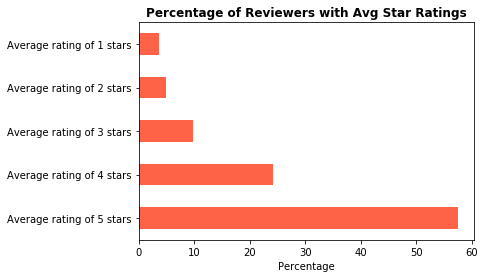

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

#Visualize average rating by users
g.pct.plot(kind = 'barh', color = 'tomato');
plt.title('Percentage of Reviewers with Avg Star Ratings', fontweight = 'bold');
plt.xlabel('Percentage');

We can see that almost 60% of users reliably rate books with 5 stars while just about 5% reliably rate books with 1 or 2 stars.

Next, we'll evaluate which words are most commonly used across all reviews.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import string
import numpy as np
from nltk import word_tokenize          
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

vect_one = CountVectorizer(max_features = 100, ngram_range = (1,1), stop_words = 'english', tokenizer = tokenize)
one_gram = vect_one.fit_transform(reviews_df.full_text)
X_one = one_gram.tocsc()

#Zip together words and their frequencies
freq_one = zip(vect_one.get_feature_names(), np.asarray(X_one.sum(axis=0)).ravel())
sort_freq_one = sorted(list(freq_one), key=lambda x: x[1], reverse = True)

In [44]:
#Print top 20 most frequent that are not punctuation marks
no_punc = [i for i in sort_freq_one if i[0] not in string.punctuation]
for feature, score in no_punc[0:20]:
    print('Feature is \"',feature, '\" with frequency',score)

Feature is " book " with frequency 1098512
Feature is " thi " with frequency 1033239
Feature is " 's " with frequency 825636
Feature is " wa " with frequency 769750
Feature is " read " with frequency 582223
Feature is " n't " with frequency 455710
Feature is " hi " with frequency 432373
Feature is " stori " with frequency 386095
Feature is " `` " with frequency 320213
Feature is " like " with frequency 315746
Feature is " love " with frequency 304099
Feature is " '' " with frequency 294849
Feature is " ha " with frequency 277895
Feature is " charact " with frequency 260829
Feature is " just " with frequency 229364
Feature is " time " with frequency 219879
Feature is " veri " with frequency 206714
Feature is " good " with frequency 205599
Feature is " did " with frequency 186531
Feature is " great " with frequency 181004


Now, let's run the same analysis with bi-grams.

In [ ]:
#del vect_one, one_gram, X_one

vect_two = CountVectorizer(max_features = 100, ngram_range = (2,2), stop_words = 'english', tokenizer = tokenize)
two_gram = vect_two.fit_transform(reviews_df.full_text)
X_two = two_gram.tocsc()

#Zip together words and their frequencies
freq_two = zip(vect_two.get_feature_names(), np.asarray(X_two.sum(axis=0)).ravel())
sort_freq_two = sorted(list(freq_two), key=lambda x: x[1], reverse = True)

In [86]:
#Print most frequent that are not punctuation marks
def check_punc(line):
    for l in line[0]:
        if l in string.punctuation:
            return
    return line

no_punc = [(lambda x: check_punc(x))(x) for x in sort_freq_two]
short = [x for x in no_punc if x is not None]
for feature, score in short:
    print('Feature is \"',feature, '\" with frequency',score)

Feature is " thi book " with frequency 368312
Feature is " read thi " with frequency 66198
Feature is " book wa " with frequency 48223
Feature is " thi wa " with frequency 40071
Feature is " read book " with frequency 34802
Feature is " thi stori " with frequency 32338
Feature is " love thi " with frequency 30928
Feature is " thi seri " with frequency 28045
Feature is " thi novel " with frequency 24794
Feature is " main charact " with frequency 23868
Feature is " enjoy thi " with frequency 23526
Feature is " like thi " with frequency 23258
Feature is " recommend thi " with frequency 23204
Feature is " book read " with frequency 21848
Feature is " wa veri " with frequency 20949


## Naive Bayes Modeling

We begin our analysis by training a Naive Bayes model to gauge sentiment classification on the book review text.

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where c represents the classification of "favorable" (overall score of 4.0 or higher) and f represents a feature vector of words.  Therefore, we are finding the probability of a favorable rating given a certain bag-of-words representation of a textual book review.

In [ ]:
def make_xy(df, vectorizer=None):
    if vectorizer is None:
         vectorizer = CountVectorizer(max_df = 0.95)
    X = vectorizer.fit_transform(df.full_text)
    X = X.tocsc() 
    y = (reviews_df.overall >= 4.0).values #pull only favorable reviews
    return X, y

X, y = make_xy(reviews_df)

In [ ]:
total = X.sum().tolist()
total_values = total[0].sort()
type(X)

In [ ]:

# # Initalize total list
# total = np.array([0] * X.shape[1])

# #Add up all reviews in X and sort
# for review in X:
#     total += review
# total = total.tolist()
# total_values = total[0].sort()

# #Create dictionary for frequencies
# d = {x:total_values.count(x) for x in total_values}

# a, b = d.keys(), d.values()
# pct = np.divide(np.cumsum(list(b)), X.shape[1])
# plt.plot(list(a), pct);
# plt.xlabel('Number of appearances');
# plt.ylabel('Pct of words');
# plt.title('Frequency of words in documents');

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state = 10)
clf = MultinomialNB()

clf.fit(xtrain, ytrain)
test_score = accuracy_score(clf.predict(xtest), ytest)
train_score = accuracy_score(clf.predict(xtrain), ytrain)
print('Accuracy of training set: {:.2f} \nAccuracy of test set: {:.2f}'.format(train_score, test_score))